# libraries and files

In [13]:
library(data.table)

In [14]:
library(msigdbr)
library(ggplot2)
library(stats)
library(sets)
library(biomaRt)
library(clusterProfiler)
library(data.table)
library(stringi)
library(pheatmap)
library(tidyr)
library(ggpubr)
library(biomaRt)
human <- readRDS("/data/timonaj/biomart_orthologs/human.RDS")

# go
go_gene_sets <- msigdbr(species = "Homo sapiens", category = "C5")
unique_go_genes <- unique(go_gene_sets$gene_symbol)

# kegg
kegg_gene_sets <- msigdbr(species = "Homo sapiens", category = "C2", subcategory = "KEGG")
unique_kegg_genes <- unique(kegg_gene_sets$gene_symbol)

# oncogenic

## hallmark
H_gene_sets <- msigdbr(species = "Homo sapiens", category = "H")
unique_H_genes <- unique(H_gene_sets$gene_symbol)

## C2
c2_gene_sets <- msigdbr(species = "Homo sapiens", category = "C2")
unique_c2_genes <- unique(c2_gene_sets$gene_symbol)


## C4 CM
c4_gene_sets <- msigdbr(species = "Homo sapiens", category = "C4", subcategory = "CM")
unique_c4_genes <- unique(c4_gene_sets$gene_symbol)

## cosmic
cosmic_set <- fread("cancer_gene_census.csv")
unique_cosmic_genes <- unique(cosmic_set$`Gene Symbol`)

# Background set of genes
background_set <- fread("background_set.txt")

pathways <- readRDS("pathways.rds")

In [26]:
wrs_list <- readRDS("wrs_list.rds")
recurrent_wrs_list <- readRDS("recurrent_wrs_list.rds")

# data download

In [15]:
### files to be downloaded

# read in the .txt file for tissue type as well as the larger gene expression file\
ptm <- proc.time()
sample_attributes <- fread(file = "/data/timonaj/gene_variability/GTEx_v7_Annotations_SampleAttributesDS.txt")
gene_tpm <- fread(file = "/data/timonaj/gene_variability/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct")
gene_tpm_copy <- as.data.frame(gene_tpm)
print("download completed in")
print(proc.time() - ptm)

[1] "download completed in"
   user  system elapsed 
 20.366   7.639  35.415 


In [16]:
# length of the numerical tpm values since the first 2 columns are characters
tpm_length <- 3:length(gene_tpm_copy)

In [17]:
head(gene_tpm_copy)

,Name,Description,GTEX-1117F-0226-SM-5GZZ7,GTEX-111CU-1826-SM-5GZYN,GTEX-111FC-0226-SM-5N9B8,GTEX-111VG-2326-SM-5N9BK,GTEX-111YS-2426-SM-5GZZQ,GTEX-1122O-2026-SM-5NQ91,GTEX-1128S-2126-SM-5H12U,GTEX-113IC-0226-SM-5HL5C,⋯,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000223972.4,DDX11L1,0.10820,0.11580,0.02104,0.02329,0.00000,0.04641,0.03076,0.09358,⋯,0.09012,0.14620,0.10450,0.00000,0.6603,0.69500,0.12130,0.41690,0.23550,0.14500
2,ENSG00000227232.4,WASH7P,21.40000,11.03000,16.75000,8.17200,7.65800,9.37200,10.08000,13.56000,⋯,3.92600,13.13000,5.53700,5.78900,8.4390,7.84300,12.39000,12.53000,8.02700,12.76000
3,ENSG00000243485.2,MIR1302-11,0.16020,0.06433,0.04674,0.00000,0.05864,0.00000,0.13670,0.20790,⋯,0.08008,0.03607,0.00000,0.10590,0.0000,0.06432,0.05388,0.00000,0.04756,0.05367
4,ENSG00000237613.2,FAM138A,0.05045,0.00000,0.02945,0.03260,0.00000,0.00000,0.08610,0.13100,⋯,0.00000,0.06818,0.07309,0.03336,0.0000,0.08105,0.00000,0.05304,0.02996,0.03381
5,ENSG00000268020.2,OR4G4P,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.11080,0.05619,⋯,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.08739,0.00000,0.00000,0.04353
6,ENSG00000240361.1,OR4G11P,0.00000,0.10510,0.07637,0.00000,0.00000,0.04212,0.00000,0.00000,⋯,0.06543,0.05895,0.04739,0.00000,0.0000,0.00000,0.04402,0.00000,0.03886,0.00000


In [18]:
### calculate the zcore for every gene

# log + 1 every value
sample_tpm <- head(gene_tpm_copy)
gene_tpm_copy[,tpm_length] <- gene_tpm_copy[,tpm_length] + 1
gene_tpm_copy[,tpm_length] <- log(gene_tpm_copy[,tpm_length])

sample_tpm[,tpm_length] <- sample_tpm[,tpm_length] + 1
sample_tpm[,tpm_length] <- log(sample_tpm[,tpm_length])

In [19]:
min(gene_tpm_copy[,tpm_length])

[1] 0

In [20]:

# convert the column names into the tissue type so it's easier to subset
ptm <- proc.time()
convoluted_tissue_types <- colnames(gene_tpm_copy)[tpm_length]
new_tt_colnames <- vector(mode = "numeric", length(convoluted_tissue_types))
for (i in 1:length(convoluted_tissue_types)) {
  new_tt_colnames[i] <- sample_attributes[sample_attributes$SAMPID == convoluted_tissue_types[i]]$SMTS
}
names(gene_tpm_copy) <- c(colnames(gene_tpm_copy)[1:2], new_tt_colnames)
print("rownames computed in")
print(proc.time() - ptm)

[1] "rownames computed in"
   user  system elapsed 
  4.603   0.150   4.764 


In [21]:
ptm <- proc.time()
# compute zscore
gene_tpm_copy[,tpm_length] <- t(apply(gene_tpm_copy[, tpm_length], MARGIN = 1, scale))
sample_tpm[,tpm_length] <- t(apply(sample_tpm[, tpm_length], MARGIN = 1, scale))
print("zscore computed in")
print(proc.time() - ptm)

[1] "zscore computed in"
   user  system elapsed 
163.888  52.223 216.626 


In [23]:
#### functions
# function to retrieve the mean zscore for a tissue type
get.most.expressed <- function(tissue_type) {
  
  # calculate mean z_score
  temp_samples <- gene_tpm_copy[which(names(gene_tpm_copy) == tissue_type)]
  
  mean_zscore <- rowMeans(temp_samples, na.rm = F)
  
  # extract the columns for the tissues of interest, in this case we want Lung, Liver, Esophagus, Bladder, and Intestine
  tissue_mean_zscore <- data.frame(cbind(gene_tpm_copy[, 1:2], "mean_Zscore" = mean_zscore))
  
  # select the top 3000 most highly expressed genes
  tissue_most_expressed <- tissue_mean_zscore[with(tissue_mean_zscore, order(mean_Zscore, decreasing = TRUE)),]
  tissue_most_expressed <- tissue_most_expressed[1:1000,]
  
  write.table(tissue_most_expressed, file = paste("/data/timonaj/cancer_as_wound/tissue_most_expressed/", gsub(" ", "_", tissue_type),"_top_1000.txt", sep = ""), sep = '\t',
              row.names = FALSE, col.names = FALSE, quote = FALSE)
}

# top 1000 tissue specific genes

In [24]:
tissue_type_names <- sub("_top_1000.txt","",list.files("/data/timonaj/tissue_most_expressed/"))
tissue_type_files <- list.files("/data/timonaj/tissue_most_expressed/")
tissue_types <- list()

for(i in 1:length(tissue_type_files)) {
    ensembl_genes <- fread(paste("/data/timonaj/tissue_most_expressed/",tissue_type_files[i],sep=""), header=FALSE)$V1
    
    mapping <- getLDS(attributes=c("ensembl_gene_id"), filters="ensembl_gene_id",
                        values=gsub("\\..*","", ensembl_genes),
                        mart=human,attributesL=c("ensembl_gene_id","hgnc_symbol"),
                        martL=human)
    
    tissue_types[[tissue_type_names[i]]] <- mapping[,"HGNC.symbol"]
}

In [25]:
summary(tissue_types)

                Length Class  Mode     
Adipose_Tissue  962    -none- character
Adrenal_Gland   962    -none- character
Bladder         939    -none- character
Blood           952    -none- character
Blood_Vessel    963    -none- character
Brain           955    -none- character
Breast          957    -none- character
Cervix_Uteri    914    -none- character
Colon           944    -none- character
Esophagus       969    -none- character
Fallopian_Tube  922    -none- character
Heart           961    -none- character
Kidney          957    -none- character
Liver           961    -none- character
Lung            957    -none- character
Muscle          969    -none- character
Nerve           949    -none- character
Ovary           937    -none- character
Pancreas        953    -none- character
Pituitary       941    -none- character
Prostate        934    -none- character
Salivary_Gland  950    -none- character
Skin            965    -none- character
Small_Intestine 938    -none- character


# functions

In [46]:
compute_enrichment <- function(foreground_genes,all_genes,background_genes=NULL,pathways=NULL) {
    if (is.null(pathways)) { 
        pathways <- load_pathways()
        pathways <- lapply( pathways, function(pathway_genes) {return(pathway_genes[pathway_genes %in% all_genes])})
    }
    fisher_enrichment_dt <- data.table(pathway=names(pathways),p_value=-1,odds_ratio=-1)
    if (is.null(background_genes)) {
        background_genes <- setdiff(all_genes,foreground_genes)
        #background_genes <- unique(unlist(pathways))
    }

    for (pathway in names(pathways)) {
        pathway_genes <- pathways[[pathway]]
        non_pathway_genes <- setdiff(all_genes,pathway_genes)

        num_in_pathway_and_foreground <- intersect(pathway_genes,foreground_genes) %>% length
        num_in_pathway_and_not_foreground <- intersect(pathway_genes,background_genes) %>% length
        num_not_in_pathway_and_foreground <- intersect(non_pathway_genes,foreground_genes) %>% length
        num_not_in_pathway_and_not_foreground <- intersect(non_pathway_genes,background_genes) %>% length
        fisher_mat <- matrix(c(num_in_pathway_and_foreground,num_in_pathway_and_not_foreground,
                              num_not_in_pathway_and_foreground,num_not_in_pathway_and_not_foreground),
                             nrow=2,ncol=2,byrow=T)
        
        test_res <- fisher.test(fisher_mat,alternative="g")
        pathway_ <- pathway
        fisher_enrichment_dt[pathway==pathway_,`:=`(p_value=test_res$p.value, odds_ratio=test_res$estimate,
        num_p_fg=num_in_pathway_and_foreground,num_p_bg=num_in_pathway_and_not_foreground,
        num_not_p_fg=num_not_in_pathway_and_foreground,num_not_p_bg=num_not_in_pathway_and_not_foreground)]
    }
    fisher_enrichment_dt[,q_value:=p.adjust(p_value)]

    return(fisher_enrichment_dt)
}

get_enrichment_data <- function(current_files, current_pathways){
    total_enrichment_pathways <- names(current_pathways)
    pathwaysDF <- data.frame("pathways" = total_enrichment_pathways)
    pathwaysDF_odds <- data.frame("pathways" = total_enrichment_pathways)
    for(i in 1:length(current_files)) {
        spec_exptype <- names(current_files)[i]
        
        current_hgnc <- getLDS(attributes=c("entrezgene_id"), filters="entrezgene_id",
                             values=current_files[[spec_exptype]],
                             mart=human,attributesL=c("hgnc_symbol"),
                             martL=human)
        total_genes <- current_hgnc$HGNC.symbol
        
        
        enrichment_test <- compute_enrichment(foreground_genes = total_genes,
                                               all_genes = background_set$gene,
                                               pathways = current_pathways)
        subset_enrichment_test  <- enrichment_test[,c("q_value")]
        subset_enrichment_test_odds  <- enrichment_test[,c("odds_ratio")]
        rownames(subset_enrichment_test) <-  enrichment_test$pathway
        rownames(subset_enrichment_test_odds) <-  enrichment_test$pathway

        pathwaysDF <- cbind(pathwaysDF, subset_enrichment_test)
        pathwaysDF_odds <- cbind(pathwaysDF_odds, subset_enrichment_test_odds)
        #saveRDS(subset_enrichment_test, file = new_file_name)
    }
    
    all_qvals <- pathwaysDF[,2:length(pathwaysDF)]
    rownames(all_qvals) <- total_enrichment_pathways
    colnames(all_qvals) <- names(current_files)
    
    all_odds <- pathwaysDF_odds[,2:length(pathwaysDF_odds)]
    rownames(all_odds) <- total_enrichment_pathways
    colnames(all_odds) <- names(current_files)
    
    enrichment_heatmap <- pheatmap(as.matrix(log(all_qvals)), fontsize = 8)
    return(list("matrix" = all_qvals, "odds_matrix" = all_odds, "heatmap" = enrichment_heatmap))
}
makeColorRampPalette <- function(colors, cutoff.fraction, num.colors.in.palette)
{
  stopifnot(length(colors) == 4)
  ramp1 <- colorRampPalette(colors[1:2])(num.colors.in.palette * cutoff.fraction)
  ramp2 <- colorRampPalette(colors[3:4])(num.colors.in.palette * (1 - cutoff.fraction))
  return(c(ramp1, ramp2))
}
change_matrix <- function(fdr_mat, odds_mat, threshhold) {
    new_mat <- matrix(nrow = nrow(fdr_mat), ncol = ncol(fdr_mat))
    
    for(i in 1:nrow(fdr_mat)) {
        for(j in 1:ncol(fdr_mat)) {
            
            if(fdr_mat[i,j] < .05) {
                new_mat[i,j] <- odds_mat[i,j]
            }else {
                new_mat[i,j] <- 0.001
            }
        }
    }
    
    rownames(new_mat) <- rownames(fdr_mat)
    colnames(new_mat) <- colnames(fdr_mat)
    
    cutoff.distance <- 0.002  
    cols <- makeColorRampPalette(c("white", "white",    # distances 0 to 0.002 colored from white to red
                                   "red", "blue"), # distances 0.002 to max(distmat) colored from green to black
                                 cutoff.distance / max(new_mat),
                                 100)
    freq_mat <- apply(new_mat, 1, function(x) {sum(x > threshhold)/nrow(new_mat)})
    freq_dat <- data.frame("cancertype" = names(freq_mat),
                     "fraction" = freq_mat)
    
    # Barplot
    bar_plot<- ggplot(freq_dat, aes(x=cancertype, y=fraction)) + 
    geom_bar(stat = "identity") +
    coord_flip()

    new_heatmap <- pheatmap(new_mat,
                            color = cols,
                            fontsize = 8)
    
    return(list("matrix"=new_mat, "heatmap" = new_heatmap, "barplot" = bar_plot))
    
}

# Tissue enrichment Plots

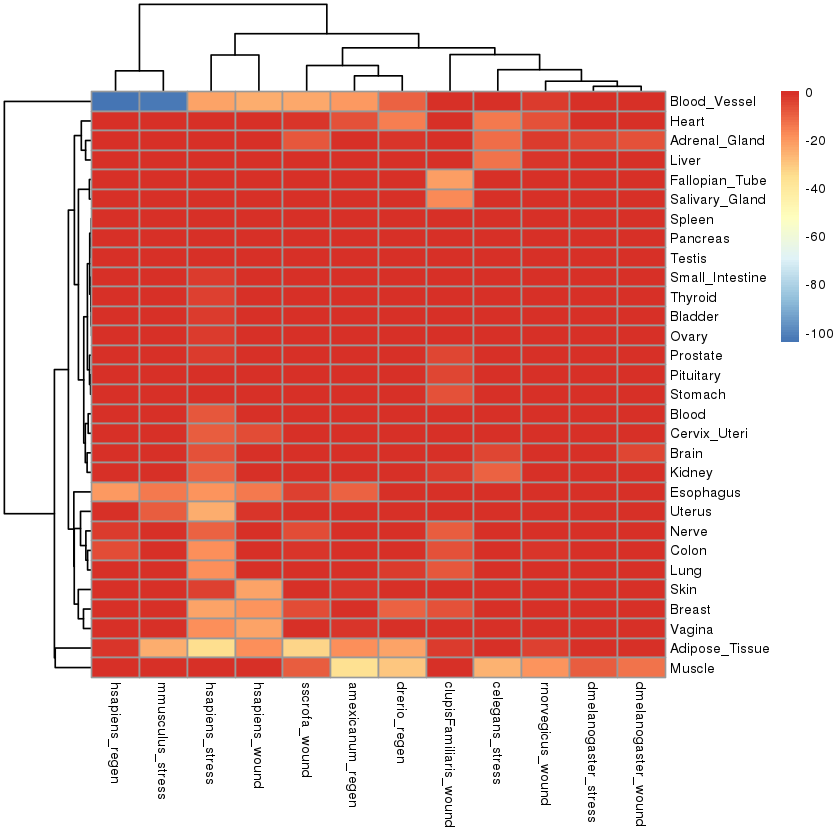

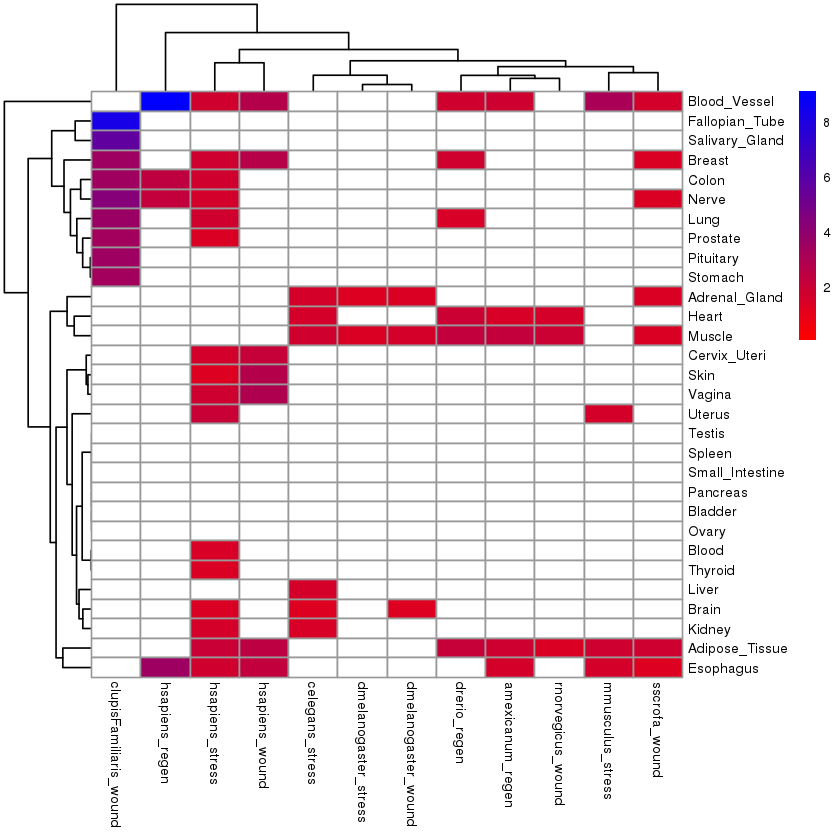

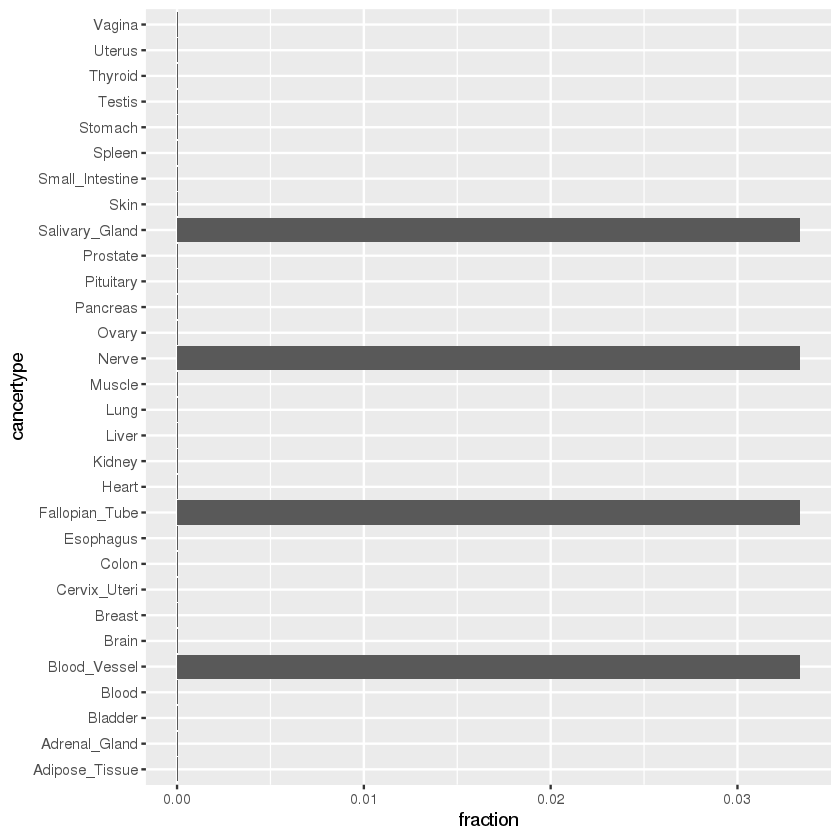

In [51]:
spec_exp_tissue_type_up <- get_enrichment_data(wrs_list[["upregulated"]], tissue_types)
spec_exp_tissue_type_up_new <- change_matrix(spec_exp_tissue_type_up$matrix, spec_exp_tissue_type_up$odds_matrix,4)
spec_exp_tissue_type_up_new$barplot

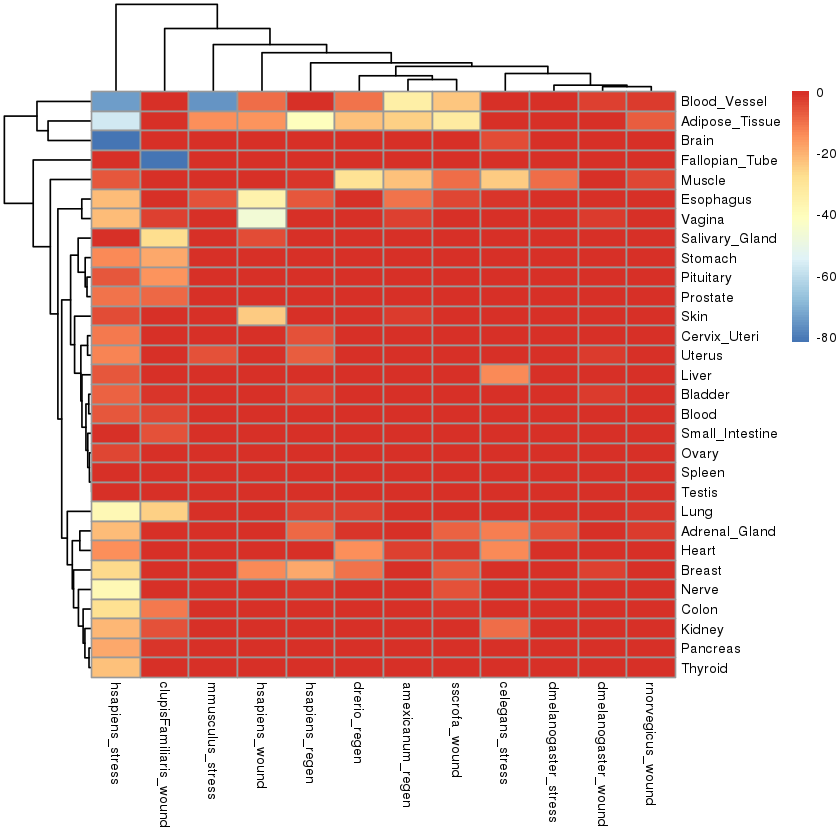

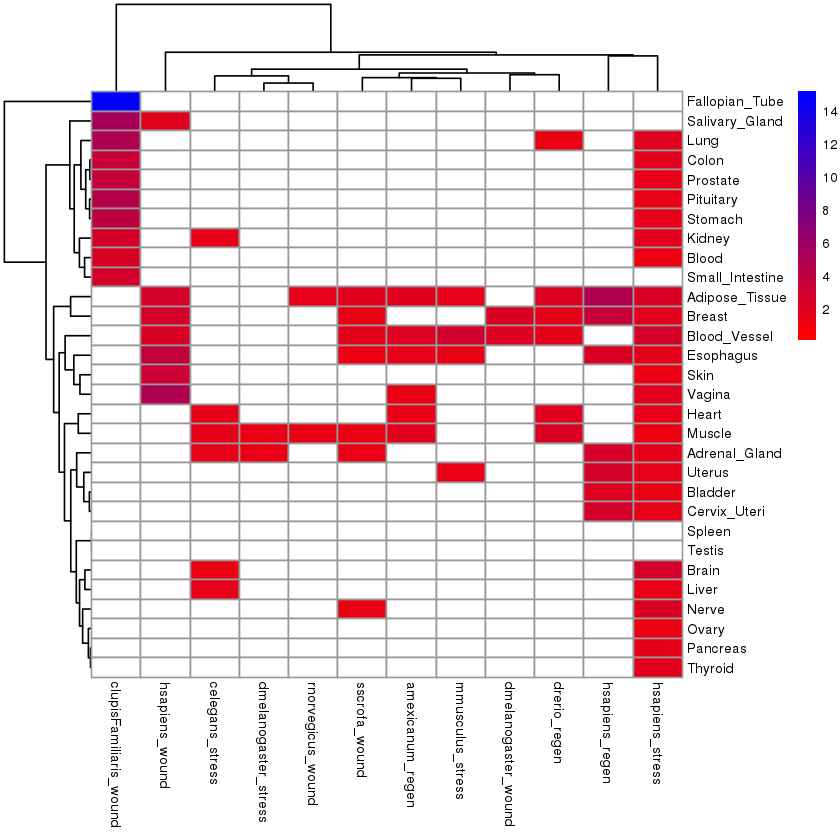

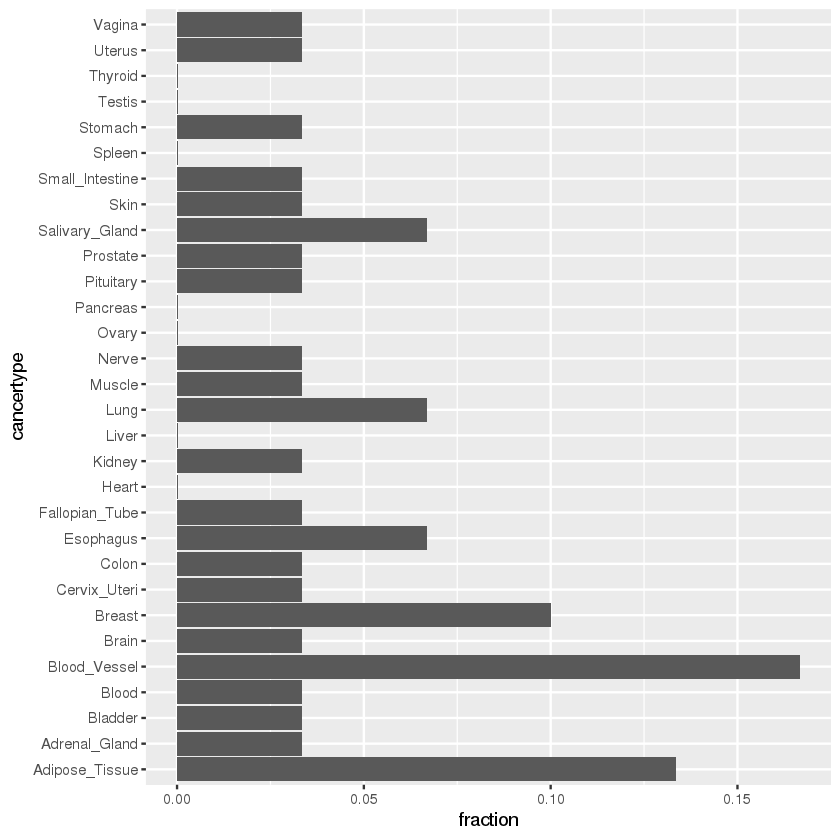

In [55]:
spec_exp_tissue_type_down <- get_enrichment_data(wrs_list[["downregulated"]], tissue_types)
spec_exp_tissue_type_down_new <- change_matrix(spec_exp_tissue_type_down$matrix, spec_exp_tissue_type_down$odds_matrix,2)
spec_exp_tissue_type_down_new$barplot

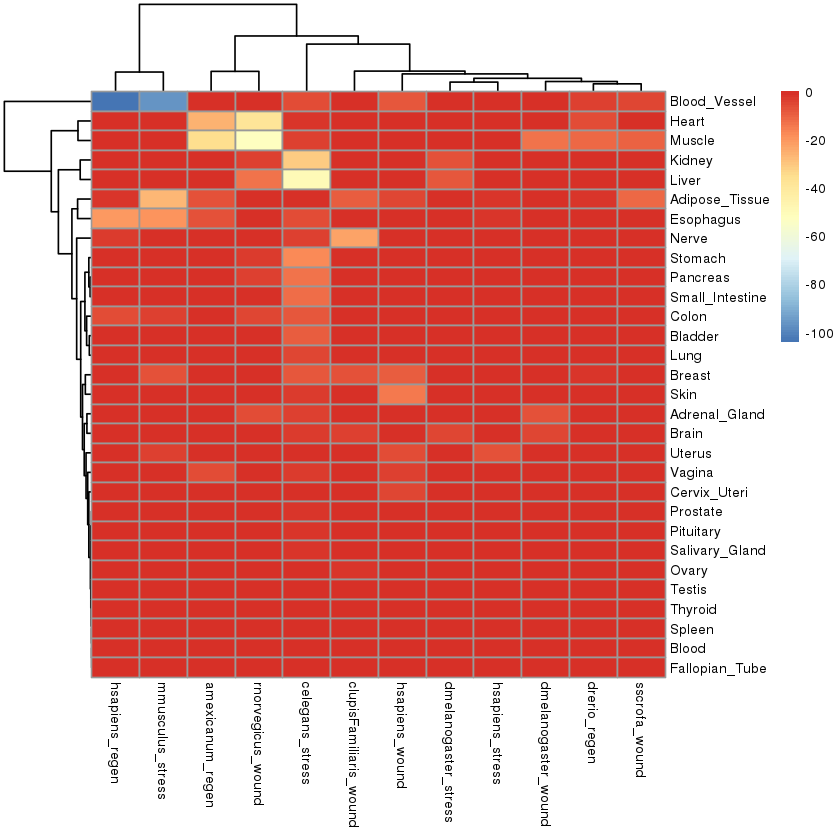

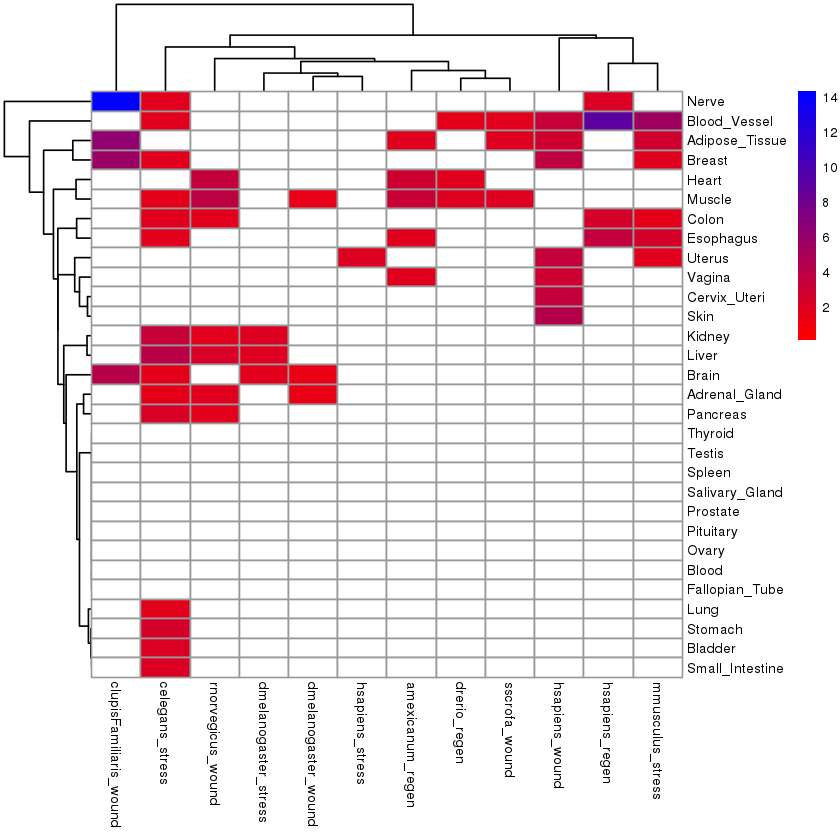

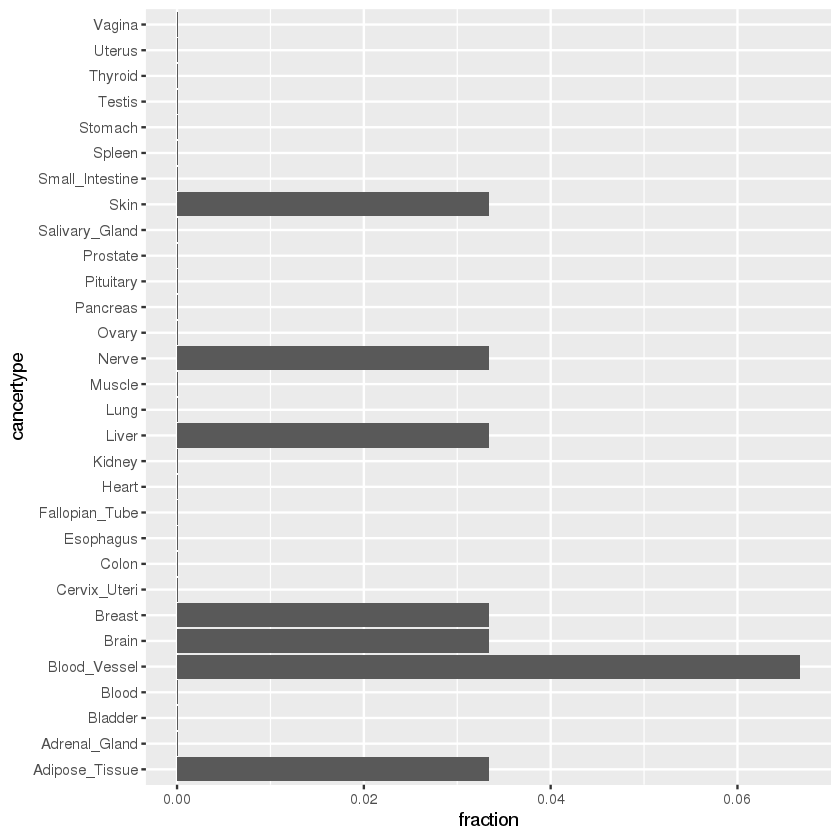

In [53]:
spec_exp_tissue_type_up_reccurent <- get_enrichment_data(recurrent_wrs_list[["upregulated"]],tissue_types)
spec_exp_tissue_type_up_reccurent_new <- change_matrix(spec_exp_tissue_type_up_reccurent$matrix,
                                                       spec_exp_tissue_type_up_reccurent$odds_matrix,4)
spec_exp_tissue_type_up_reccurent_new$barplot

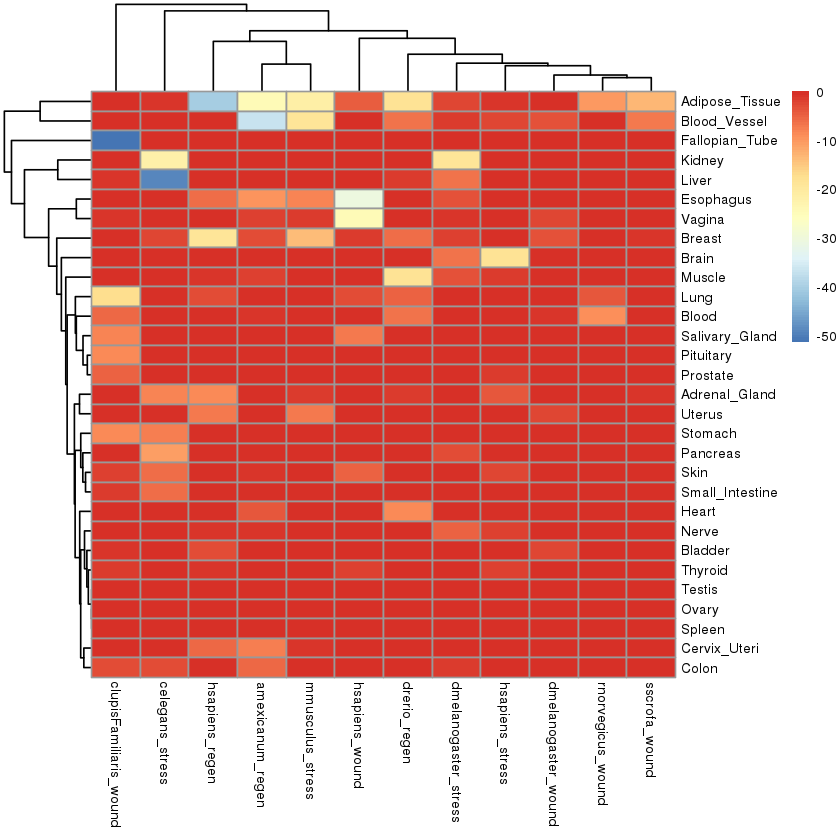

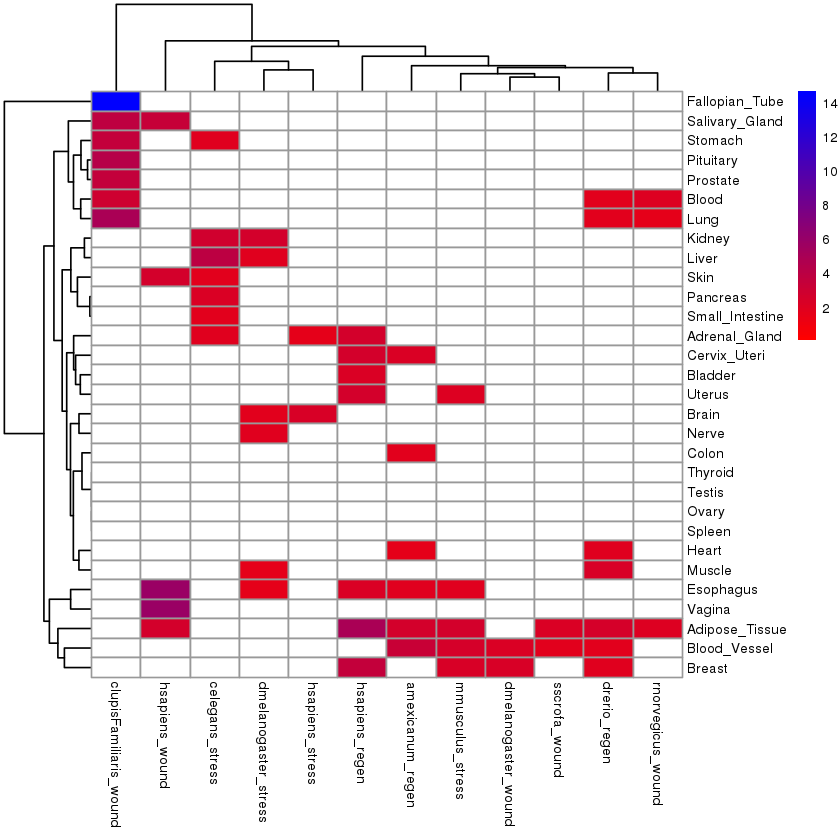

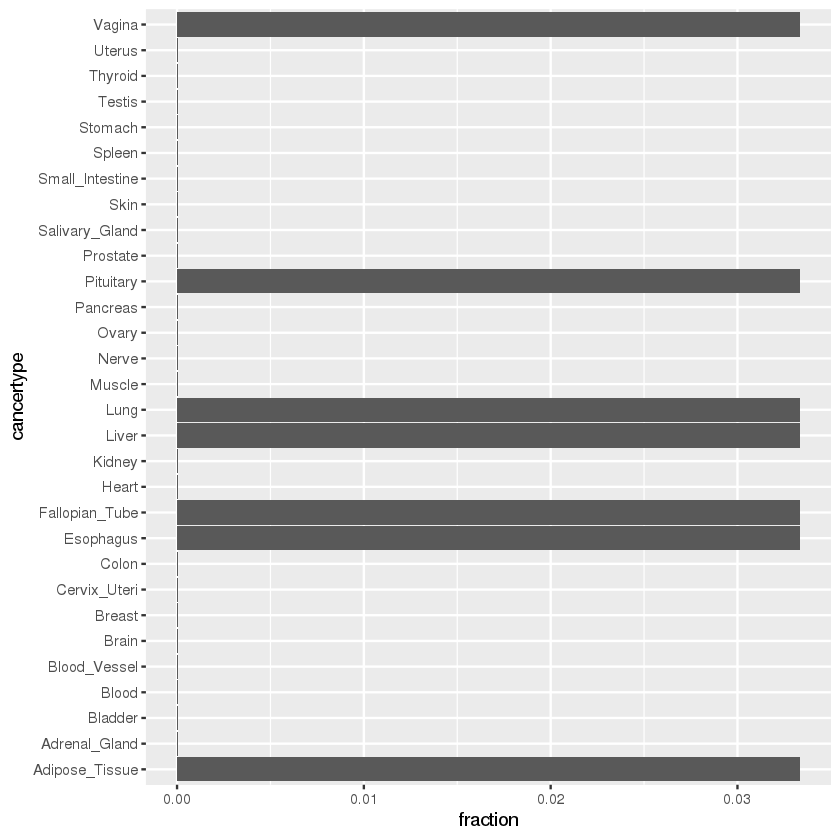

In [54]:
spec_exp_tissue_type_down_reccurent <- get_enrichment_data(recurrent_wrs_list[["downregulated"]],tissue_types)
spec_exp_tissue_type_down_reccurent_new <- change_matrix(spec_exp_tissue_type_down_reccurent$matrix,
                                                       spec_exp_tissue_type_down_reccurent$odds_matrix,4)
spec_exp_tissue_type_down_reccurent_new$barplot